# Improving Diffusion Model Baed on Immiscible Diffusion : 

```bibtex
@misc{li2024immisciblediffusionacceleratingdiffusion,
      title={Immiscible Diffusion: Accelerating Diffusion Training with Noise Assignment}, 
      author={Yiheng Li and Heyang Jiang and Akio Kodaira and Masayoshi Tomizuka and Kurt Keutzer and Chenfeng Xu},
      year={2024},
      eprint={2406.12303},
      archivePrefix={arXiv},
      primaryClass={cs.CV},
      url={https://arxiv.org/abs/2406.12303}, 
}
```

In [1]:
from dataclasses import dataclass
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
import torchvision
from torchvision import transforms

@dataclass
class TrainingConfig:
    image_size = 256  # the generated image resolution
    train_batch_size = 2
    train_immiscible_batch_size = 16
    eval_batch_size = 4  # how many images to sample during evaluation
    num_epochs = 100
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "samples_immiscible_hq"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()
config.dataset_name = "data"

assert config.train_immiscible_batch_size % config.train_batch_size == 0, "immiscible_batch_size must be divisible by train_batch_size"

In [2]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)
dataset = torchvision.datasets.ImageFolder(config.dataset_name, preprocess)
dataset

Dataset ImageFolder
    Number of datapoints: 2271
    Root location: data
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

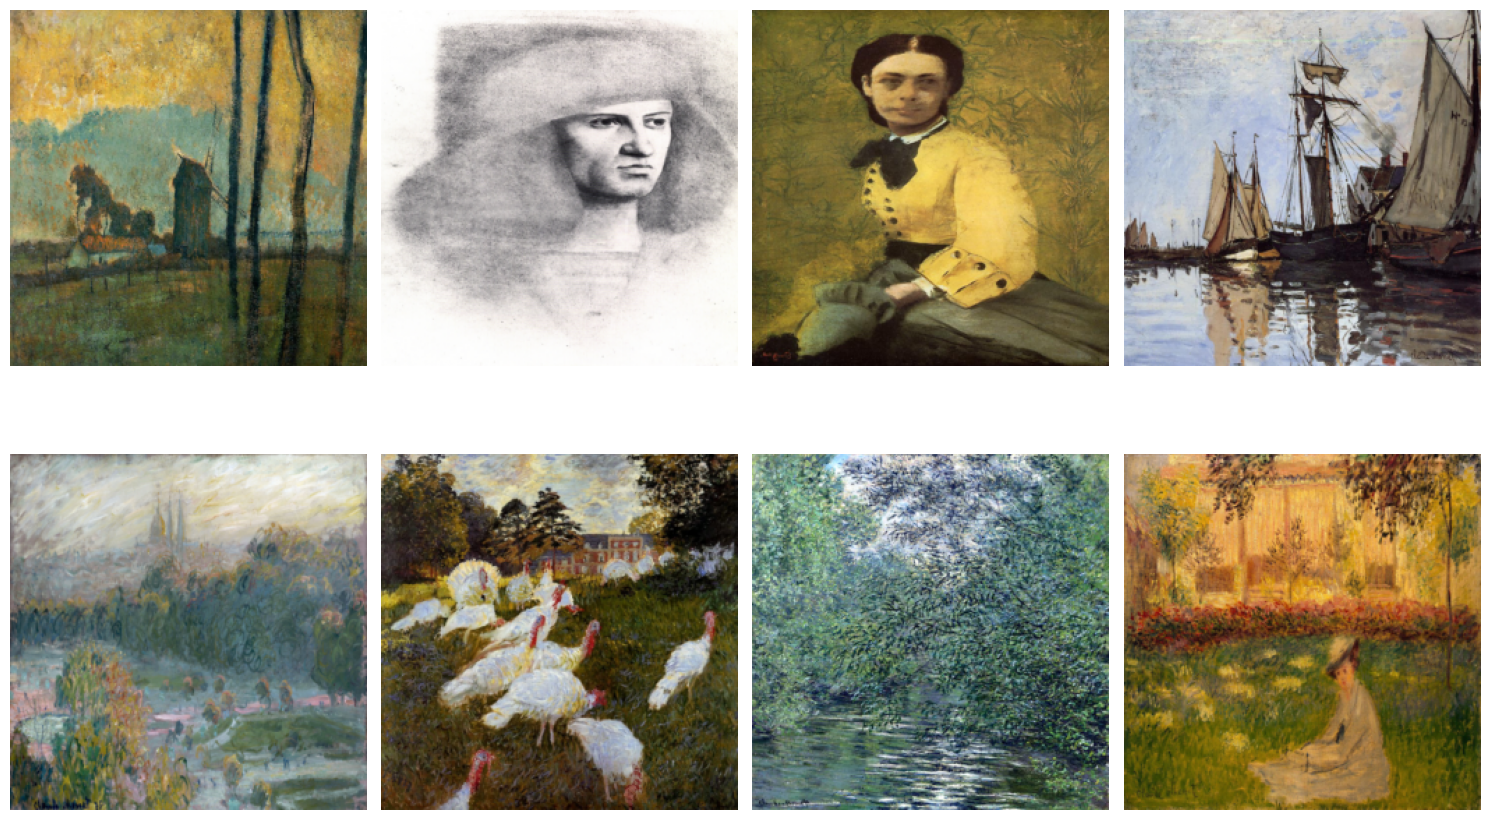

In [3]:
# Show the first 12 images of the dataset
fig, ax = plt.subplots(2, 4, figsize=(15, 10))  # 3 rows, 4 columns
for i in range(8):
    row, col = divmod(i, 4)  # Compute row and column indices
    ax[row, col].imshow(((dataset[i][0].permute(1, 2, 0) + 1) / 2))
    ax[row, col].axis("off")
plt.tight_layout()
plt.show()


In [4]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_immiscible_batch_size, shuffle=True)

In [5]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [6]:
sample_image = dataset[0][0].unsqueeze(0)
print("Input shape:", sample_image.shape)
print("Output shape:", model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 3, 256, 256])


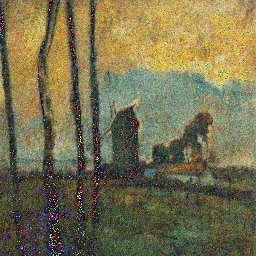

In [7]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)
Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [8]:
import torch.nn.functional as F
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [9]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [10]:
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device='cpu').manual_seed(config.seed), # Use a separate torch generator to avoid rewinding the random state of the main training loop
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=2, cols=2)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [11]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
import time
import csv
from scipy.optimize import linear_sum_assignment

log_file = os.path.join(config.output_dir, "training_logs.csv")

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
            ).repo_id
        accelerator.init_trackers("train_example")
    
# Create a log file to save metrics
    if accelerator.is_main_process:
        log_filec = os.path.join(config.output_dir, "training_logs.csv")
        with open(log_file, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["global_step", "epoch", "step", "loss", "learning_rate"])

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

    
        for step, batch in enumerate(train_dataloader):
            clean_images = batch[0].to(accelerator.device)
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )
            # Add this single block for optimal noise assignment
            dist_matrix = torch.cdist(clean_images.view(bs, -1), noise.view(bs, -1))
            row_ind, col_ind = linear_sum_assignment(dist_matrix.cpu().numpy())
            noise = noise[col_ind]  # Rearrange noise based on assignment

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            batch_loss = 0.0

            # Train the model
            for d in range(config.train_immiscible_batch_size // config.train_batch_size):

                # select a batch of images
                noisy_images_sub_batch = noisy_images[d * config.train_batch_size : (d + 1) * config.train_batch_size]
                timestep_sub_batch = timesteps[d * config.train_batch_size : (d + 1) * config.train_batch_size]
                noise_sub_batch = noise[d * config.train_batch_size : (d + 1) * config.train_batch_size]
                
                with accelerator.accumulate(model):
                    # Predict the noise residual
                    noise_pred_sub_batch = model(noisy_images_sub_batch, timestep_sub_batch, return_dict=False)[0]
                    loss_sub_batch = F.mse_loss(noise_pred_sub_batch, noise_sub_batch)
                    accelerator.backward(loss_sub_batch)

                    if accelerator.sync_gradients:
                        accelerator.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()
                    lr_scheduler.step()
                    optimizer.zero_grad()
                    batch_loss += loss.detach().item()

            progress_bar.update(1)
            logs = {"loss": batch_loss, "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            if accelerator.is_main_process:
                with open(log_file, mode='a', newline='') as f:
                    writer = csv.writer(f)
                    writer.writerow([global_step, epoch, step, logs["loss"], logs["lr"]])

            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1
        # empty cache
        torch.cuda.empty_cache()
        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

In [ ]:
from accelerate import notebook_launcher
torch.cuda.empty_cache()
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/142 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 7.76 GiB of which 6.75 MiB is free. Process 1941668 has 5.85 GiB memory in use. Including non-PyTorch memory, this process has 1.81 GiB memory in use. Of the allocated memory 1.67 GiB is allocated by PyTorch, and 15.17 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)